In [1]:
from typing import TypedDict, List, Dict, Any, Literal, Callable, NamedTuple
import json
from pydantic import BaseModel, Field
from prompt_engineer import *
import pandas as pd
from tqdm import notebook
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
import os


## Experiment 1: IMDB Sentiment Analysis with Prompt Optimization

### Creating a dataset

In [ ]:
class InitialPromptOutputFormat(BaseModel):
    """Output format for the initial prompt."""
    sentiment: bool = Field(..., description="sentiment analysis of the text either positive/True or negarive/False")
    other: str = Field(..., description="Everything else requested by the prompt in string format.")

initial_prompt=PromptTemplateData(
    prompt="For the following given text return true if the sentiment is positive, otherwise return false. \nText: {text}",
    system_prompt="You are an expert in extracting the comment sentiment from the given text.",
    output_format=InitialPromptOutputFormat,
    prompt_format_function=text_format_function
)

In [ ]:
train = pd.read_csv("Train.csv")

if not os.path.exists("bad_data.csv"):
    # Function to process a single row for multiprocessing
    def process_single_row(row_data):
        """Process a single row for LLM call - needs to be at module level for pickling"""
        index, row = row_data
        
        # Create the prompt template for this specific row
        prompt = PromptTemplateData(
            prompt="For the following given text return true if the sentiment is positive, otherwise return false. \nText: {text}",
            system_prompt="You are an expert in extracting the comment sentiment from the given text.",
            output_format=InitialPromptOutputFormat,
            prompt_format_function=lambda x, y: x.format(text=y)
        )
        
        # Format the prompt with the text
        formatted_prompt = prompt(row['text'])
        
        # Make the LLM call
        llm_response = llm_call(
            prompt=formatted_prompt,
            model="gpt-4o-mini"
        )
        return index, row, llm_response

    # creating a dataset where gpt-4o-mini performs poorly
    bad_data = {'text': [], 'label': []}

    # Prepare data for multiprocessing
    rows_to_process = [(index, row) for index, row in train.iterrows()]

    # Use multiprocessing with progress tracking
    max_workers = min(mp.cpu_count(), 8)  # Adjust based on API rate limits
    batch_size = 50  # Process in batches to avoid overwhelming the API

    print(f"Using {max_workers} workers for parallel processing...")

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit batches of work
        futures = []
        for i in range(0, len(rows_to_process), batch_size):
            batch = rows_to_process[i:i + batch_size]
            batch_futures = [executor.submit(process_single_row, row_data) for row_data in batch]
            futures.extend(batch_futures)
            
            # Process completed futures from this batch
            for future in as_completed(batch_futures):
                try:
                    index, row, llm_response = future.result()
                    if llm_response.sentiment != (row['label'] == 1):
                        bad_data['text'].append(row['text'])
                        bad_data['label'].append(row['label'])
                    
                    # Break early if we have enough bad examples
                    if len(bad_data['text']) >= 100:
                        # Cancel remaining futures
                        for f in futures:
                            f.cancel()
                        break
                        
                except Exception as e:
                    print(f"Error processing row {index}: {e}")
            
            # Break if we have enough data
            if len(bad_data['text']) >= 100:
                break
            
            print(f"Processed batch {i//batch_size + 1}, found {len(bad_data['text'])} bad examples so far...")

    training_dataset = pd.DataFrame(bad_data)
    print(f"Created training dataset with {len(training_dataset)} examples")
    training_dataset.to_csv("bad_data.csv", index=False)
else:
    training_dataset = pd.read_csv("bad_data.csv")
    print(f"Loaded existing training dataset with {len(training_dataset)} examples")

### Evaluation Method

In [ ]:

def process_single_evaluation(args):
    """Process a single row for evaluation - needs to be at module level for pickling"""
    prompt, row_data, model = args
    index, row = row_data
    
    formatted_prompt = prompt(row['text'])
    llm_response = llm_call(formatted_prompt,temperature=0, model=model)
    prediction = 1 if llm_response.sentiment else 0
    
    return index, prediction, row['label'], row['text']

def evaluation_method(prompt: PromptTemplateData, dataset: pd.DataFrame) -> Dict[str, float]:
    def convert_to_sentiment(x):
        return "positive" if x == 1 else "negative"
    # Prepare data for multiprocessing
    rows_to_process = [(index, row) for index, row in dataset.iterrows()]
    
    # Create arguments for each process
    process_args = [(prompt, row_data, "gpt-4o-mini") for row_data in rows_to_process]
    
    # Use multiprocessing with progress tracking
    max_workers = mp.cpu_count()  # Adjust based on API rate limits
    
    predictions = []
    actual = []
    failure_cases = []
    
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        futures = [executor.submit(process_single_evaluation, args) for args in process_args]
        
        # Collect results with progress bar
        for future in as_completed(futures):
            try:
                index, prediction, label, text = future.result()
                predictions.append(prediction)
                actual.append(label)
                
                # Check for failure cases
                if prediction != label:
                    failure_cases.append(f"text: {text}| predicted: {convert_to_sentiment(prediction)}| actual: {convert_to_sentiment(label)}")
                    
            except Exception as e:
                print(f"Error processing row: {e}")
                # Handle failed cases by adding default values
                predictions.append(0)
                actual.append(0)
    
    # Calculate metrics
    precision = sum(p == a == 1 for p, a in zip(predictions, actual)) / sum(p == 1 for p in predictions) if sum(p == 1 for p in predictions) > 0 else 0
    recall = sum(p == a == 1 for p, a in zip(predictions, actual)) / sum(a == 1 for a in actual) if sum(a == 1 for a in actual) > 0 else 0
    
    return {
        "accuracy": sum(p == a for p, a in zip(predictions, actual)) / len(actual),
        "recall": recall,
        "precision": precision,
        "f1_score": 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0,
        "false_positive_rate": sum(p == 1 and a == 0 for p, a in zip(predictions, actual)) / sum(a == 0 for a in actual) if sum(a == 0 for a in actual) > 0 else 0,
        "failure_cases": failure_cases
    }

In [ ]:
MAX_ITERATIONS = 100
for EPSILON in notebook.tqdm([0, 0.1, 0.3]):
    for DROP_OUT in notebook.tqdm([0, 0.3, 0.5]):
        random.seed(42)  # Reset seed for reproducibility
        print(f"Running with EPSILON={EPSILON}, DROP_OUT={DROP_OUT}, MAX_ITERATIONS={MAX_ITERATIONS}")
        po = PromptOptimizer(
            evaluation_method=evaluation_method,     # evaluation method for demonstration
            training_dataset=training_dataset,
            action_selection=movie_review_action_selection_prompt,
            action_application=movie_review_action_application,
            initial_prompt=initial_prompt,
            action_list=IMPROVEMENT_ACTIONS,
            train_test_ratio=0.5,
            max_iterations=MAX_ITERATIONS,
            epsilon=EPSILON,
            drop_out=DROP_OUT,
        )
        final_state = po.run()
        save_final_state(final_state, EPSILON, DROP_OUT, MAX_ITERATIONS)

#po.visualize()

In [ ]:
plot_cumulative_max_f1_scores()

## Experiment 2: e-SNLI dataset with Prompt Optimization

### Creating a dataset

In [2]:
import pandas as pd
import os
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp
import requests
from io import StringIO

class NLIOutputFormat(BaseModel):
    relationship: str

def format_esnli_prompt(template, variables):
    return template.format(premise=variables['premise'], hypothesis=variables['hypothesis'])

esnli_prompt = PromptTemplateData(
        prompt="""Given the premise and hypothesis below, determine their logical relationship.

Premise: {premise}
Hypothesis: {hypothesis}

Determine if the hypothesis is:
- entailment: logically follows from the premise
- contradiction: contradicts the premise
- neutral: neither follows nor contradicts

Return only one word: entailment, neutral, or contradiction.""",
        system_prompt="You are an expert in natural language inference and logical reasoning.",
        output_format=NLIOutputFormat,
        prompt_format_function=format_esnli_prompt
    )

In [3]:


# Function to process a single row for multiprocessing - DEFINED AT MODULE LEVEL
def process_single_row(row_data):
    """Process a single row for LLM call - needs to be at module level for pickling"""
    index, row = row_data
    
    # Create the prompt template for this specific row
    prompt = esnli_prompt
    
    # Format the prompt with the premise and hypothesis
    formatted_prompt = prompt({
        'premise': row['Sentence1'],  
        'hypothesis': row['Sentence2']
    })
    
    # Make the LLM call
    llm_response = llm_call(
        prompt=formatted_prompt,
        model="gpt-4o-mini"
    )
    return index, row, llm_response

# Download e-SNLI dataset
def download_esnli():
    """Download e-SNLI dataset from GitHub repository"""
    base_url = "https://raw.githubusercontent.com/OanaMariaCamburu/e-SNLI/master/dataset"
    
    train_files = [
        f"{base_url}/esnli_train_1.csv",
        f"{base_url}/esnli_train_2.csv"
    ]
    
    dfs = []
    for url in train_files:
        try:
            print(f"Downloading from {url}...")
            response = requests.get(url, timeout=30)
            if response.status_code == 200:
                df = pd.read_csv(StringIO(response.text))
                dfs.append(df)
                print(f"Successfully loaded {len(df)} examples")
        except Exception as e:
            print(f"Could not download {url}: {e}")
    
    if dfs:
        train_df = pd.concat(dfs, ignore_index=True)
        return train_df
    else:
        raise Exception("Could not download any training data")

if not os.path.exists("bad_data_esnli.csv"):
    # Download the dataset
    print("Downloading e-SNLI dataset...")
    train = download_esnli()

    print(f"\nLoaded {len(train)} training examples")
    print("Columns:", train.columns.tolist())

    # Take a subset for testing
    train = train.head(5000)
    # creating a dataset where gpt-4o-mini performs poorly
    bad_data = {
        'premise': [], 
        'hypothesis': [], 
        'label': [],
        'explanation_1': [],
        'explanation_2': [],
        'explanation_3': []
    }

    # Prepare data for multiprocessing
    rows_to_process = [(index, row) for index, row in train.iterrows()]

    # Use multiprocessing with progress tracking
    max_workers = min(mp.cpu_count(), 8)  # Adjust based on API rate limits
    batch_size = 50  # Process in batches to avoid overwhelming the API

    print(f"Using {max_workers} workers for parallel processing...")

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit batches of work
        futures = []
        for i in range(0, len(rows_to_process), batch_size):
            batch = rows_to_process[i:i + batch_size]
            batch_futures = [executor.submit(process_single_row, row_data) for row_data in batch]
            futures.extend(batch_futures)
            
            # Process completed futures from this batch
            for future in as_completed(batch_futures):
                try:
                    index, row, llm_response = future.result()
                    
                    # Get predicted and true labels
                    predicted_label = llm_response.relationship.lower().strip()
                    true_label = row['gold_label'].lower().strip()
                    
                    # Check if prediction is wrong
                    if predicted_label != true_label:
                        bad_data['premise'].append(row['Sentence1'])
                        bad_data['hypothesis'].append(row['Sentence2'])
                        bad_data['label'].append(true_label)
                        bad_data['explanation_1'].append(row['Explanation_1'])
                        bad_data['explanation_2'].append(row.get('Explanation_2', ''))
                        bad_data['explanation_3'].append(row.get('Explanation_3', ''))
                    
                    # Break early if we have enough bad examples
                    if len(bad_data['premise']) >= 100:
                        # Cancel remaining futures
                        for f in futures:
                            f.cancel()
                        break
                        
                except Exception as e:
                    print(f"Error processing row {index}: {e}")
            
            # Break if we have enough data
            if len(bad_data['premise']) >= 100:
                break
            
            print(f"Processed batch {i//batch_size + 1}, found {len(bad_data['premise'])} bad examples so far...")

    training_dataset = pd.DataFrame(bad_data)
    print(f"Created training dataset with {len(training_dataset)} examples")
    training_dataset.to_csv("bad_data_esnli.csv", index=False)
else:
    training_dataset = pd.read_csv("bad_data_esnli.csv")
    print(f"Loaded existing training dataset with {len(training_dataset)} examples")

# Display statistics
print("\n" + "="*50)
print("Dataset Statistics:")
print("="*50)
print(f"Total bad examples: {len(training_dataset)}")
if len(training_dataset) > 0:
    print("\nLabel distribution:")
    print(training_dataset['label'].value_counts())
    print("\n" + "="*50)
    print("Sample bad example:")
    print("="*50)
    sample = training_dataset.iloc[0]
    print(f"Premise: {sample['premise']}")
    print(f"Hypothesis: {sample['hypothesis']}")
    print(f"True label: {sample['label']}")
    print(f"Explanation: {sample['explanation_1']}")

Loaded existing training dataset with 100 examples

Dataset Statistics:
Total bad examples: 100

Label distribution:
label
entailment       40
neutral          37
contradiction    23
Name: count, dtype: int64

Sample bad example:
Premise: A boy is jumping on skateboard in the middle of a red bridge.
Hypothesis: The boy does a skateboarding trick.
True label: entailment
Explanation: jumping on skateboard is the same as doing trick on skateboard.


### Evaluation method

In [4]:
def process_single_evaluation_nli(args):
    """Process a single row for NLI evaluation - needs to be at module level for pickling"""
    prompt, row_data, model = args
    index, row = row_data
    
    # Format the prompt with premise and hypothesis
    formatted_prompt = prompt({
        'premise': row['premise'], 
        'hypothesis': row['hypothesis']
    })
    llm_response = llm_call(formatted_prompt, temperature=0, model=model)
    prediction = llm_response.relationship.lower().strip()
    
    # Get explanations
    explanations = []
    if pd.notna(row.get('explanation_1')):
        explanations.append(row['explanation_1'])
    if pd.notna(row.get('explanation_2')):
        explanations.append(row['explanation_2'])
    if pd.notna(row.get('explanation_3')):
        explanations.append(row['explanation_3'])
    
    return index, prediction, row['label'], row['premise'], row['hypothesis'], explanations

def evaluation_method_nli(prompt: PromptTemplateData, dataset: pd.DataFrame) -> Dict[str, float]:
    """Evaluation method for Natural Language Inference (NLI) dataset"""
    # Prepare data for multiprocessing
    rows_to_process = [(index, row) for index, row in dataset.iterrows()]
    
    # Create arguments for each process
    process_args = [(prompt, row_data, "gpt-4o-mini") for row_data in rows_to_process]
    
    # Use multiprocessing with progress tracking
    max_workers = mp.cpu_count()  # Adjust based on API rate limits
    
    predictions = []
    actual = []
    failure_cases = []
    
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        futures = [executor.submit(process_single_evaluation_nli, args) for args in process_args]
        
        # Collect results with progress bar
        for future in as_completed(futures):
            try:
                index, prediction, label, premise, hypothesis, explanations = future.result()
                predictions.append(prediction)
                actual.append(label)
                
                # Check for failure cases
                if prediction != label:
                    # Format explanations
                    explanation_str = ""
                    if explanations:
                        explanation_str = " | ".join([f"explanation_{i+1}: {exp}" for i, exp in enumerate(explanations) if exp])
                    
                    failure_case = f"premise: {premise} | hypothesis: {hypothesis} | predicted: {prediction} | actual: {label}"
                    if explanation_str:
                        failure_case += f" | {explanation_str}"
                    
                    failure_cases.append(failure_case)
                    
            except Exception as e:
                print(f"Error processing row: {e}")
                # Handle failed cases by adding default values
                predictions.append("neutral")  # Default to neutral for NLI
                actual.append("neutral")
    
    # Calculate metrics for multi-class classification
    # Convert to numerical labels for easier calculation
    label_map = {"entailment": 0, "neutral": 1, "contradiction": 2}
    
    # Handle any unexpected labels by mapping them to neutral
    pred_numeric = []
    actual_numeric = []
    
    for p, a in zip(predictions, actual):
        pred_numeric.append(label_map.get(p, 1))  # Default to neutral (1) if unknown
        actual_numeric.append(label_map.get(a, 1))  # Default to neutral (1) if unknown
    
    # Calculate overall accuracy
    accuracy = sum(p == a for p, a in zip(pred_numeric, actual_numeric)) / len(actual_numeric)
    
    # Calculate per-class precision, recall, and F1
    classes = ["entailment", "neutral", "contradiction"]
    class_metrics = {}
    
    for i, cls in enumerate(classes):
        # True positives, false positives, false negatives
        tp = sum(p == a == i for p, a in zip(pred_numeric, actual_numeric))
        fp = sum(p == i and a != i for p, a in zip(pred_numeric, actual_numeric))
        fn = sum(p != i and a == i for p, a in zip(pred_numeric, actual_numeric))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        class_metrics[f"{cls}_precision"] = precision
        class_metrics[f"{cls}_recall"] = recall
        class_metrics[f"{cls}_f1"] = f1
    
    # Calculate macro-averaged metrics
    macro_precision = sum(class_metrics[f"{cls}_precision"] for cls in classes) / len(classes)
    macro_recall = sum(class_metrics[f"{cls}_recall"] for cls in classes) / len(classes)
    macro_f1 = sum(class_metrics[f"{cls}_f1"] for cls in classes) / len(classes)
    
    return {
        "accuracy": accuracy,
        "precision": macro_precision,
        "recall": macro_recall,
        "f1_score": macro_f1,
        "failure_cases": failure_cases,
        **class_metrics  # Include per-class metrics
    }

In [7]:
MAX_ITERATIONS = 200
esnli_prompt = PromptTemplateData(
        prompt="Given the premise and hypothesis below, determine their logical relationship by addressing these subtasks step-by-step:\n\n1. **Identify Synonyms and Rephrasing:**\n   - Detect rephrased terms or synonyms between the premise and hypothesis. Evaluate if different wording affects their relationship. **Focus on:** Direct synonyms and clear rephrases, such as \"making\" and \"sculpting.\" **Example:** \"bikers\" implies \"people on bicycles.\"\n   \n   **Example 1:**\n   - Premise: \"A group of bikers rides through town.\"\n   - Hypothesis: \"Several people are cycling in the city.\"\n   - Relationship: entailment\n\n2. **Evaluate Logical Implications:**\n   - Analyze if the premise logically implies the hypothesis or if they present conflicting scenarios. **Focus on:** Direct implications without assumptions, like \"walking along a path\" implying \"admiring the water nearby.\" **Example:** \"A horse pulling a cart\" implies \"an animal walking outside.\"\n   \n   **Example 2:**\n   - Premise: \"A man reads a book by the window.\"\n   - Hypothesis: \"Someone is reading indoors.\"\n   - Relationship: entailment\n\n3. **Analyze Contextual Considerations:**\n   - Consider explicit contexts. Identify if multiple interpretations affect the conclusion. **Focus on:** Provided contexts, such as distinguishing between \"forest\" and \"wooded area\" without inferring additional scenarios. **Example:** \"A lake\" is not the same as any body of water.\n   \n   **Example 3:**\n   - Premise: \"Children play in a park full of trees.\"\n   - Hypothesis: \"Kids are playing in a wooded area.\"\n   - Relationship: neutral\n\n4. **Consider Edge Cases:**\n   - Evaluate scenarios with subtle connections or implications. **Focus on:** Scenarios with subtle or implicit meanings that may affect the classification, such as differences in context or assumptions. **Example:** \"Stopping\" does not necessarily mean \"taking a rest,\" and not all \"water\" is a \"lake.\"\n   \n   **Example 4:**\n   - Premise: \"A woman stops to tie her shoe.\"\n   - Hypothesis: \"She is taking a rest.\"\n   - Relationship: contradiction\n\n5. **Check Action and Description Alignment:**\n   - Assess if actions described in the premise align with those in the hypothesis. **Focus on:** Explicit actions and descriptions, like \"getting on a train\" aligning with \"just getting on a train.\" **Example:** \"Watching\" implies a visual action occurring.\n   \n   **Example 5:**\n   - Premise: \"A man boards a train.\"\n   - Hypothesis: \"He is entering a vehicle.\"\n   - Relationship: entailment\n\n6. **Integrate Reasoning:**\n   - Combine findings from synonyms, implications, contexts, edge cases, and action alignment to determine the relationship. **Focus on:** Explicit evidence over assumptions, ensuring differences like \"gray hair\" versus \"blonde hair\" are considered. **Example:** \"Standing on a filled cart\" implies \"a cart full of items.\"\n\n7. **Verification Step:**\n   - Reassess the initial conclusion by reviewing the findings from each subtask. Ask: Does the conclusion remain consistent when re-evaluated against each subtask? If not, identify which subtask might alter the conclusion.\n\n8. **Explain Your Reasoning:**\n   - Provide a detailed explanation of the thought process and logic used to reach the conclusion.\n\nAfter addressing these subtasks, determine if the hypothesis is:\n- entailment: logically follows from the premise following specific criteria\n- contradiction: directly opposes the premise based on clear evidence\n- neutral: neither follows nor contradicts without clear logical connection\n\nProvide a step-by-step reasoning before returning only one word: entailment, neutral, or contradiction.\n\nPremise: {premise}\nHypothesis: {hypothesis}",
        system_prompt="You are an expert in natural language inference and logical reasoning.",
        output_format=NLIOutputFormat,
        prompt_format_function=format_esnli_prompt
    )
for EPSILON in notebook.tqdm([0.3]):#0, 0.1, 
    for DROP_OUT in notebook.tqdm([0.5]): #0, 0.3, 
        random.seed(42)  # Reset seed for reproducibility
        print(f"Running with EPSILON={EPSILON}, DROP_OUT={DROP_OUT}, MAX_ITERATIONS={MAX_ITERATIONS}")
        po = PromptOptimizer(
            evaluation_method=evaluation_method_nli,     # evaluation method for demonstration
            training_dataset=training_dataset,
            action_selection=esnli_action_selection_prompt,
            action_application=esnli_action_application,
            initial_prompt=esnli_prompt,
            action_list=IMPROVEMENT_ACTIONS,
            train_test_ratio=0.5,
            max_iterations=MAX_ITERATIONS,
            epsilon=EPSILON,
            drop_out=DROP_OUT,
        )
        final_state = po.run()
        save_final_state(final_state, EPSILON, DROP_OUT, MAX_ITERATIONS)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running with EPSILON=0.3, DROP_OUT=0.5, MAX_ITERATIONS=200
current prompt: Given the premise and hypothesis below, determine their logical relationship by addressing these subtasks step-by-step:

1. **Identify Synonyms and Rephrasing:**
   - Detect rephrased terms or synonyms between the premise and hypothesis. Evaluate if different wording affects their relationship. **Focus on:** Direct synonyms and clear rephrases, such as "making" and "sculpting." **Example:** "bikers" implies "people on bicycles."
   
   **Example 1:**
   - Premise: "A group of bikers rides through town."
   - Hypothesis: "Several people are cycling in the city."
   - Relationship: entailment

2. **Evaluate Logical Implications:**
   - Analyze if the premise logically implies the hypothesis or if they present conflicting scenarios. **Focus on:** Direct implications without assumptions, like "walking along a path" implying "admiring the water nearby." **Example:** "A horse pulling a cart" implies "an animal walking

Loaded epsilon_0.3_max_0.5_iter_200.json: 200 iterations, final best F1: 0.510


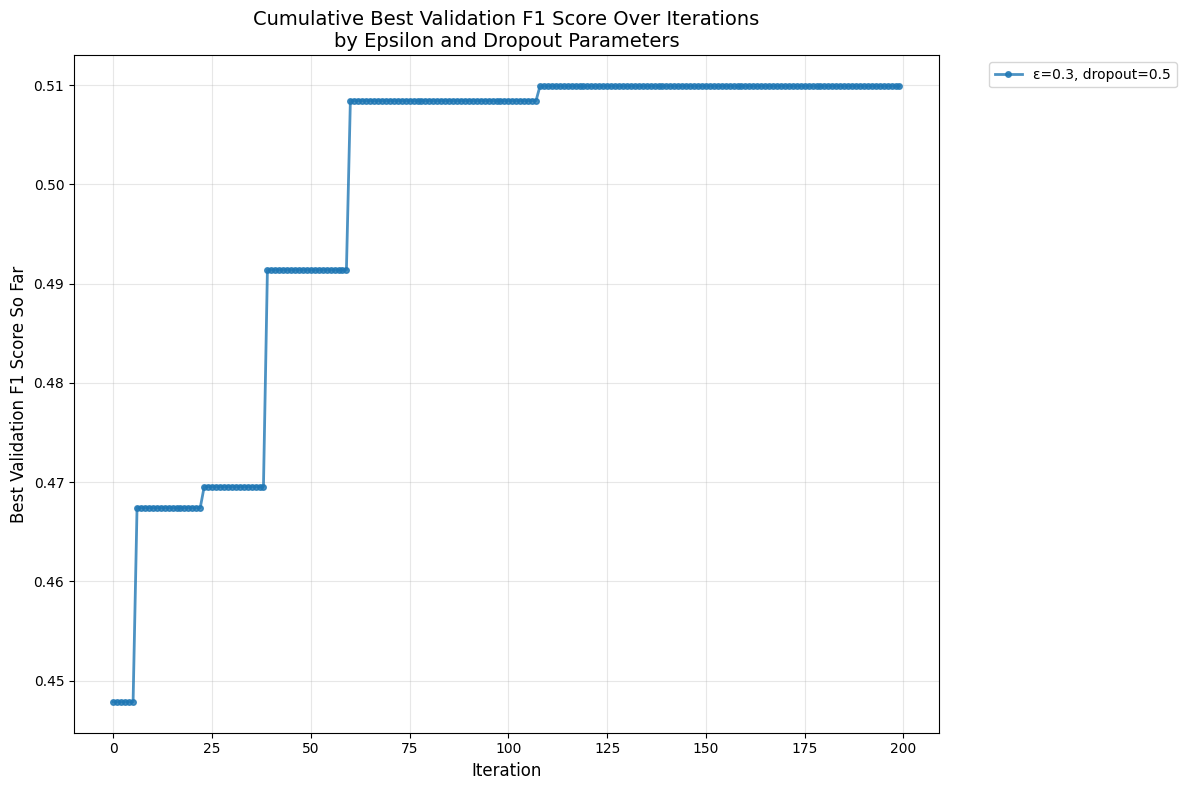

Plot saved as 'cumulative_max_f1_comparison.png'


<Figure size 640x480 with 0 Axes>

In [9]:
plot_cumulative_max_f1_scores()

In [10]:
print("Given the premise and hypothesis below, determine their logical relationship by addressing these subtasks step-by-step, adhering to the following constraints:\n\n1. **Identify Synonyms and Rephrasing:**\n   - Detect rephrased terms or synonyms between the premise and hypothesis. Evaluate if different wording affects their relationship. **Focus on:** Direct synonyms and clear rephrases, such as \"making\" and \"sculpting.\" **Example:** \"bikers\" implies \"people on bicycles.\"\n   - **Constraint:** Avoid assuming equivalence unless synonyms or rephrases are explicitly clear. Clarify if synonyms imply the same context or action.\n\n   **Example 1:**\n   - Premise: \"A group of bikers rides through town.\"\n   - Hypothesis: \"Several people are cycling in the city.\"\n   - Relationship: entailment\n\n2. **Evaluate Logical Implications:**\n   - Analyze if the premise logically implies the hypothesis or if they present conflicting scenarios. **Focus on:** Direct implications without assumptions, like \"walking along a path\" implying \"admiring the water nearby.\" **Example:** \"A horse pulling a cart\" implies \"an animal walking outside.\"\n   - **Constraint:** Avoid drawing implications without direct evidence from the premise. Specify if actions or states imply certain activities or scenarios.\n\n   **Example 2:**\n   - Premise: \"A man reads a book by the window.\"\n   - Hypothesis: \"Someone is reading indoors.\"\n   - Relationship: entailment\n\n3. **Analyze Contextual Considerations:**\n   - Consider explicit contexts. Identify if multiple interpretations affect the conclusion. **Focus on:** Provided contexts, such as distinguishing between \"forest\" and \"wooded area\" without inferring additional scenarios. **Example:** \"A lake\" is not the same as any body of water.\n   - **Constraint:** Contexts should be explicitly stated or clearly implied without assumptions. Clarify if the context directly influences the relationship.\n\n   **Example 3:**\n   - Premise: \"Children play in a park full of trees.\"\n   - Hypothesis: \"Kids are playing in a wooded area.\"\n   - Relationship: neutral\n\n4. **Consider Edge Cases:**\n   - Evaluate scenarios with subtle connections or implications. **Focus on:** Scenarios with subtle or implicit meanings that may affect the classification, such as differences in context or assumptions. **Example:** \"Stopping\" does not necessarily mean \"taking a rest,\" and not all \"water\" is a \"lake.\"\n   - **Constraint:** Address edge cases by focusing on explicit information rather than assumptions. Specify the subtle differences that may affect interpretation. **Clarify actions vs. states:** Clearly distinguish between actions (e.g., stopping vs. resting) and states (e.g., waiting vs. doing an activity).\n\n   **Example 4:**\n   - Premise: \"A woman stops to tie her shoe.\"\n   - Hypothesis: \"She is taking a rest.\"\n   - Relationship: contradiction\n\n5. **Check Action and Description Alignment:**\n   - Assess if actions described in the premise align with those in the hypothesis. **Focus on:** Explicit actions and descriptions, like \"getting on a train\" aligning with \"just getting on a train.\" **Example:** \"Watching\" implies a visual action occurring.\n   - **Constraint:** Ensure actions are directly aligned by explicit description. Specify if the actions or states directly correlate.\n\n   **Example 5:**\n   - Premise: \"A man boards a train.\"\n   - Hypothesis: \"He is entering a vehicle.\"\n   - Relationship: entailment\n\n6. **Integrate Reasoning:**\n   - Combine findings from synonyms, implications, contexts, edge cases, and action alignment to determine the relationship. **Focus on:** Explicit evidence over assumptions, ensuring differences like \"gray hair\" versus \"blonde hair\" are considered. **Example:** \"Standing on a filled cart\" implies \"a cart full of items.\"\n   - **Constraint:** Prioritize explicit evidence over inferred assumptions. Clearly articulate the combined reasoning.\n\n7. **Verification Step:**\n   - Reassess the initial conclusion by reviewing the findings from each subtask. Ask: Does the conclusion remain consistent when re-evaluated against each subtask? If not, identify which subtask might alter the conclusion. Cross-verify each finding to ensure accuracy.\n   - **Constraint:** Ensure consistency by cross-verifying each finding.\n\n8. **Explain Your Reasoning:**\n   - Provide a detailed explanation of the thought process and logic used to reach the conclusion.\n\nAfter addressing these subtasks, determine if the hypothesis is:\n- entailment: logically follows from the premise following specific criteria\n- contradiction: directly opposes the premise based on clear evidence\n- neutral: neither follows nor contradicts without clear logical connection\n\nProvide a step-by-step reasoning before returning only one word: entailment, neutral, or contradiction.\n\nPremise: {premise}\nHypothesis: {hypothesis}")

Given the premise and hypothesis below, determine their logical relationship by addressing these subtasks step-by-step, adhering to the following constraints:

1. **Identify Synonyms and Rephrasing:**
   - Detect rephrased terms or synonyms between the premise and hypothesis. Evaluate if different wording affects their relationship. **Focus on:** Direct synonyms and clear rephrases, such as "making" and "sculpting." **Example:** "bikers" implies "people on bicycles."
   - **Constraint:** Avoid assuming equivalence unless synonyms or rephrases are explicitly clear. Clarify if synonyms imply the same context or action.

   **Example 1:**
   - Premise: "A group of bikers rides through town."
   - Hypothesis: "Several people are cycling in the city."
   - Relationship: entailment

2. **Evaluate Logical Implications:**
   - Analyze if the premise logically implies the hypothesis or if they present conflicting scenarios. **Focus on:** Direct implications without assumptions, like "walking al